# Three Qubit Rotation Using Pulse

In [1]:
from qiskit import IBMQ
from qiskit import pulse, assemble
from qiskit.pulse import DriveChannel, ControlChannel, Play, Schedule
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import json

import qiskit.tools.jupyter

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-university', group='uni-pittsburgh', project='main')

C:\Users\jsten\Anaconda3\envs\qiskit20_new\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


First we load a backend

In [2]:
backend = provider.get_backend('ibmq_bogota')


backend_config = backend.configuration()
dt = backend_config.dt
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map

Then we define the two qubit pulse gate.  This is pulled from parametric_cz_builder.py which was built by Daniel Egger.  Several support functions are needed including single qubit gates, the "atomic" ZX gate which pulls the schedual from parametric_cz_builder.py, and a function which checks the coupling direction between qubits.

In [18]:
from parametric_cz_builder import ParametericCZBuilder

def cx_in_forward_direction(qc: int, qt: int) -> bool:
    qc_num_inst_forward = len(inst_sched_map.get('cx', qubits=[qc, qt]))
    qc_num_inst_reverse = len(inst_sched_map.get('cx', qubits=[qt, qc]))
    if qc_num_inst_forward < qc_num_inst_reverse:
        return True
    else:
        return False

def apply_atomic_ZX(qc, qt, theta) -> Schedule:
    if cx_in_forward_direction(qc=qc, qt=qt):
        scaled_atomic_zx = ParametericCZBuilder(backend)
        return scaled_atomic_zx.parameterized_cx(theta, qc, qt)
    else:
        print('Atomic ZX applied in wrong direction!')
        return None
    

def apply_X(qubit) -> Schedule:
    return inst_sched_map.get('x', qubits=[qubit]) 

def apply_u2(qubit, phi, lamb) -> Schedule:
    return inst_sched_map.get('u2', P0=phi, P1=lamb, qubits=[qubit])

def apply_Y90p(qubit) -> Schedule:
    return apply_u2(qubit, phi=0, lamb=0)

def apply_Y90m(qubit) -> Schedule:
    return apply_u2(qubit, phi=np.pi, lamb=np.pi)
    
def R_ZX(qc, qt, theta) -> Schedule: # (fun) TODO: break into atomic & U instructions
    with pulse.build(name="Echoed ZX") as sched:
        if cx_in_forward_direction(qc=qc, qt=qt):
            with pulse.align_sequential():
                pulse.call(apply_atomic_ZX(qc, qt, theta))
                pulse.call(apply_X(qc))
        else:
            with pulse.align_sequential():
                pulse.call(apply_Y90p(qt))
                pulse.call(apply_Y90m(qc))
                pulse.call(apply_atomic_ZX(qt, qc, theta))
                pulse.call(apply_Y90p(qc))
                pulse.call(apply_Y90m(qt))
    return sched

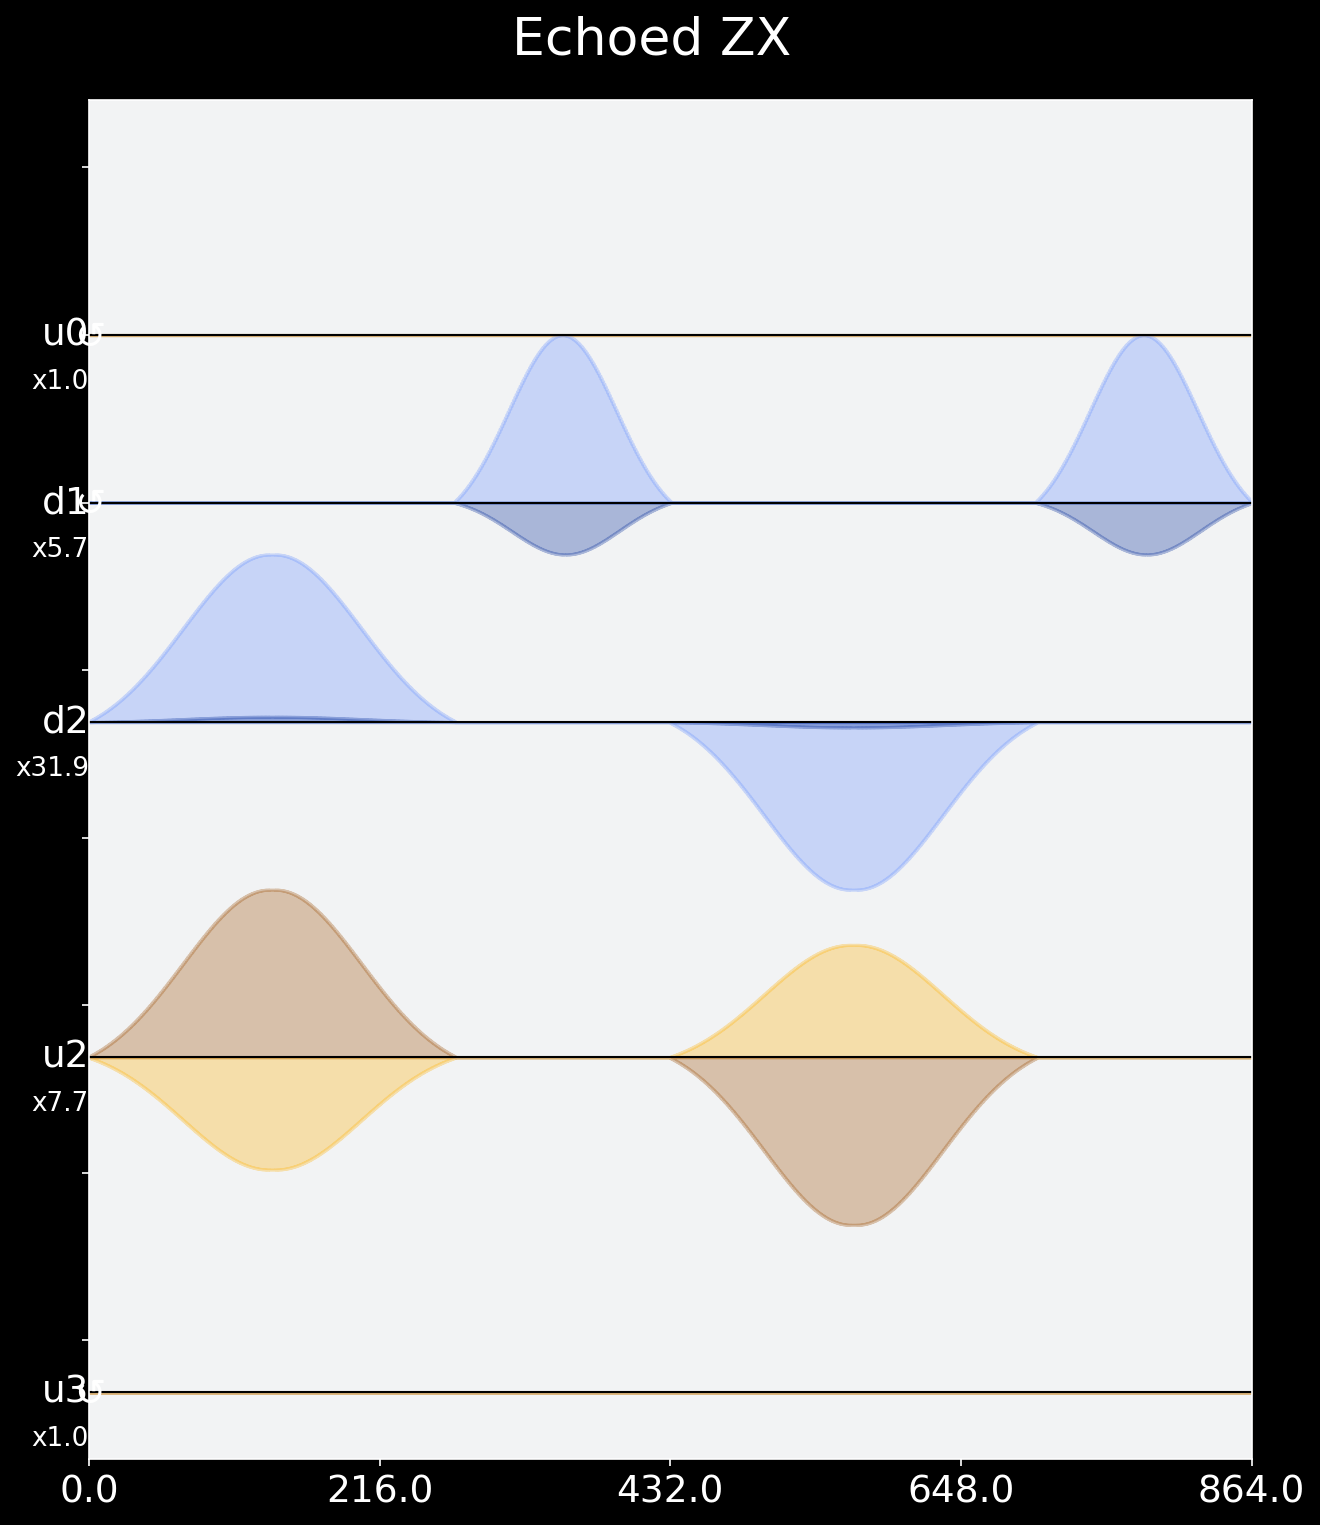

In [20]:
test = apply_echoed_ZX(1,2,0.3)
test.draw()

In order to define the three qubit gate, we need to import the list of optimized angles imported from mathematica 

In [21]:
angles = []
f = open("angles.txt", "r")
lines = f.readlines()
for line in lines:
    line = line.replace('{','')
    line = line.replace('}','')
    line = line.replace('\n','')
    line = line.replace('*^', 'e')
    angle_l = line.split(',')
    angle_n = [float(angle_l[i]) for i in range(0,3)]
    angles.append(angle_n)
f.close()
angles = np.array(angles)

Now we define a map between the desired input angles and the angles which go into the two qubit rotations

In [25]:
def a(angle):
    h = angle[0]
    l = angle[1]
    t = angle[2]
    a1 = np.cos(-h+t)*np.cos(-h-l)*np.cos(h)*np.cos(h)
    a2 = np.sin(-h+t)*np.cos(-h-l)*np.sin(h)*np.cos(h)
    a3 = np.sin(-h+t)*np.sin(-h-l)*np.sin(h)*np.sin(h)
    a4 = np.cos(-h+t)*np.sin(-h-l)*np.cos(h)*np.sin(h)
    return a1 - a2 - a3 - a4

phi_to_theta = {np.arccos(a(angles[i])):i for i in range(0,len(angles))}
def theta(phi):
    key = min(phi_to_theta.keys(), key=lambda k: abs(k-phi)) #finds the closest key to the desired angle
    index = phi_to_theta[key]
    return angles[index]


With all of this in place, we can define the three qubit rotation gate

In [26]:
def R_ZYX(q1,q2,q3,phi):
    h = theta(phi)[0]
    l = theta(phi)[1]
    t = theta(phi)[2]
    R1 = R_ZX(q1,q2,h)
    R2 = R_ZX(q2,q3,h)
    R3 = R_ZX(q1,q2,-h-l)
    R4 = R_ZX(q2,q3,-h+t)
    with pulse.build() as sched:
        with pulse.align_sequential():
            pulse.call(R1)
            pulse.call(R2)
            pulse.call(R3)
            pulse.call(R4)
    return sched

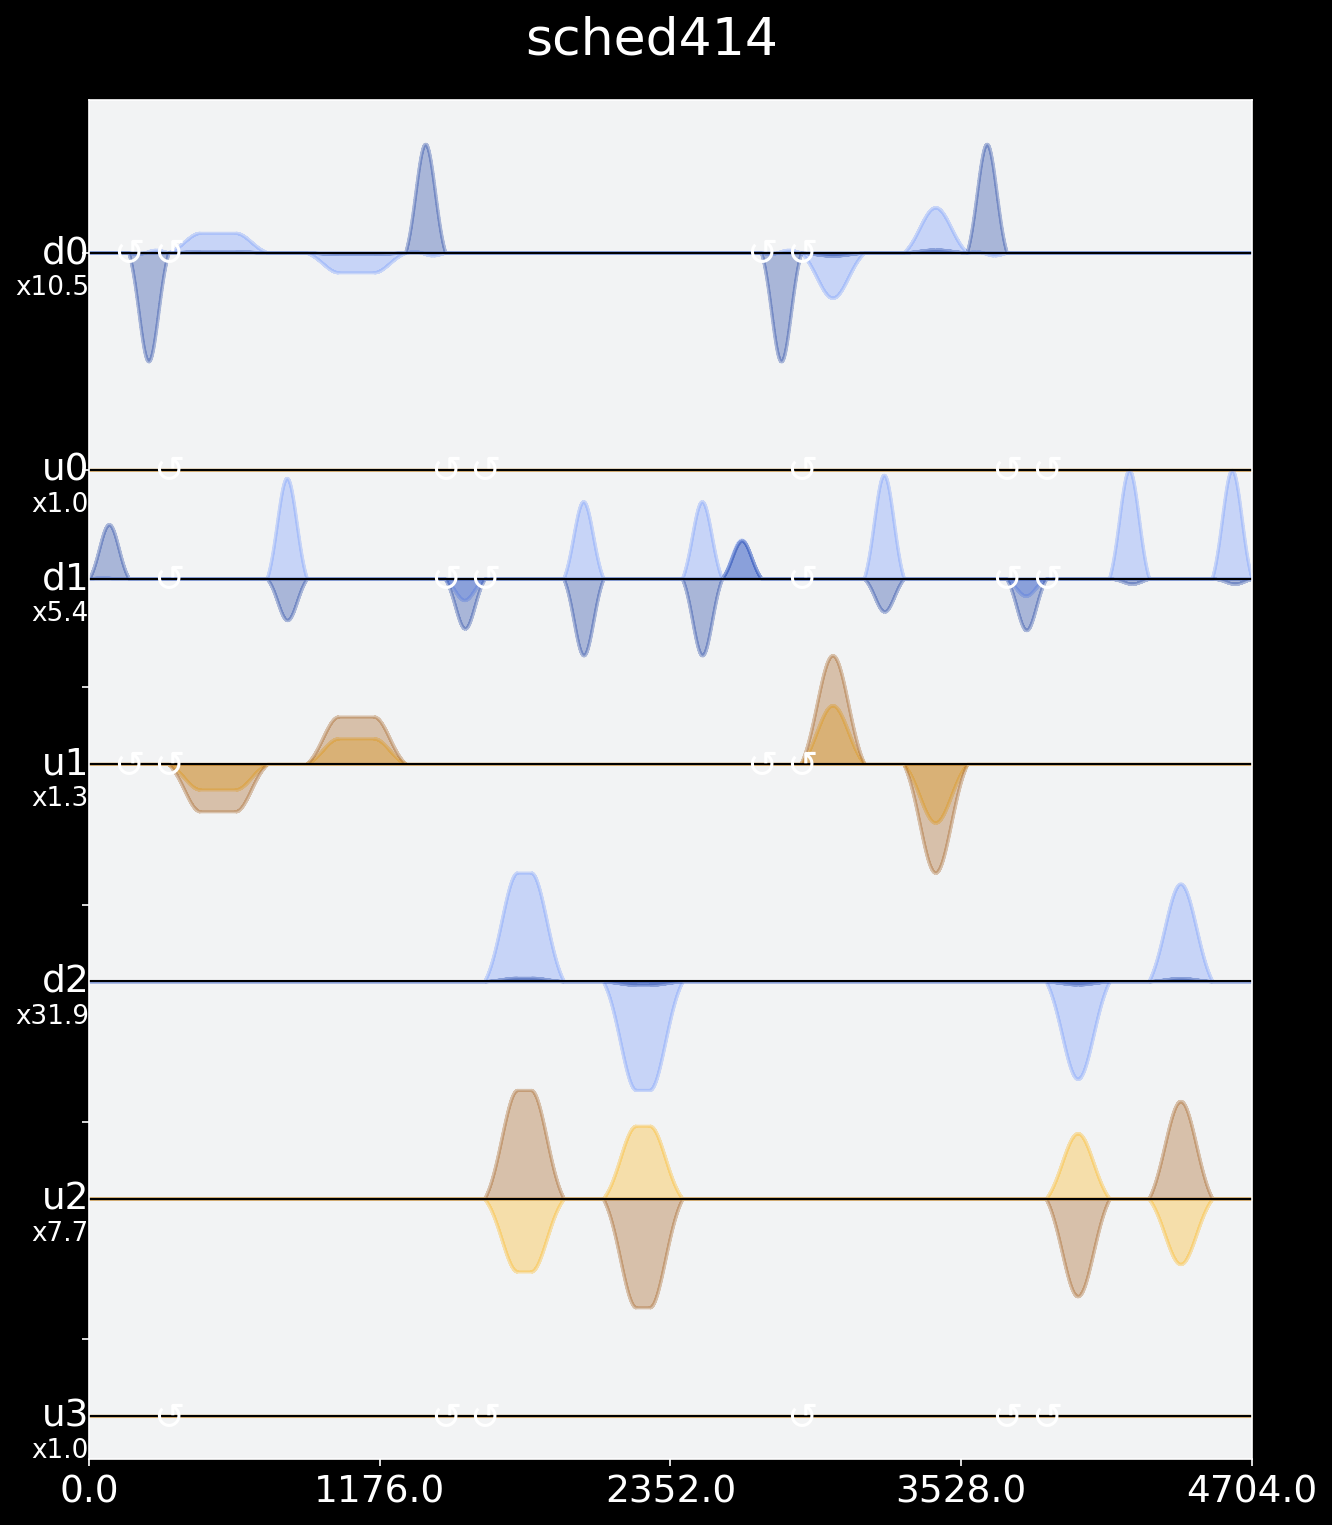

In [28]:
test = R_ZYX(0,1,2,0.3)
test.draw()

Now let us assemble the gate to a schedual and run it on the backend

In [29]:
meas = inst_sched_map.get('measure', qubits=range(backend_config.n_qubits))

with pulse.build() as sched:
    with pulse.align_sequential():
            pulse.call(R_ZYX(0,1,2,0.3))
            pulse.call(meas)

experiment = assemble(sched,
                       backend=backend,
                       meas_level=2,
                       shots=8192)

C:\Users\jsten\Anaconda3\envs\qiskit20_new\lib\site-packages\qiskit\compiler\assemble.py:293: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [30]:
job = backend.run(experiment)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

600069529264011c7af8b736
Job Status: job has successfully run


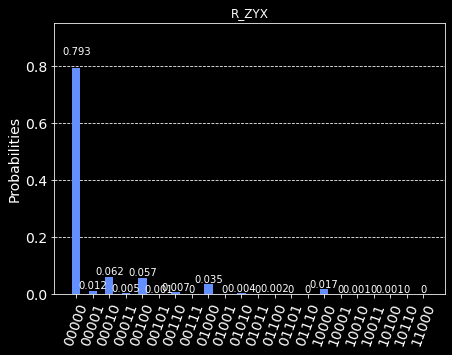

In [32]:
data = job.result().get_counts(sched)
plot_histogram(data, title='R_ZYX')